#  pyC$^2$Ray Source and Sink Models

In this tutorial we illustrate some of the source and sink model implemented in pyC$^2$Ray. In the future, we plan to add more models, but this tutorial will give you an idea on how to implement your model, if needed.

In [61]:
import pyc2ray as pc2r
import numpy as np, yaml
import matplotlib.pyplot as plt

from tqdm import tqdm

from astropy.cosmology import Planck18 as cosmo

As for most of the example scripts, we group the simulation paramateres in the dedicated file.

In [17]:
param_file = './parameters.yml'

with open(param_file) as f:
    params = yaml.safe_load(f)
    
N = params['Grid']['meshsize']

In [ ]:
# TODO: source models, mean-free path

## Clumping Factor
We define the gas clumping factor based on the cell-wise averaged quantities of the simulated intergalactic (IGM) density field:

$$ \mathcal{C} = \frac{\left< n^2_\mathrm{IGM}\right>}{\left< n_\mathrm{IGM}\right>^2} $$

For homogeneous density, this quantity is close to unity, but if matter distribution within the volume can a few order of magnitude larger.

<div align="center">
    <a name="scaling"><img src="example_clump.png" width="300" height="auto"></img></a>
</div>

In the figure here above, we illustrate how a volume (a voxel in a simulation) can have the same density, $\left<n_\mathrm{IGM}\right>$, but different clumping factor. In the left panel, an homogeneous field has $\mathcal{C} = 1$, while an highly inhomogeneous field (right panel) the clumping is, $\mathcal{C} \geq 1$.

Here, we look at the clumping model implemented in pyC$^2$Ray that can be selected in the parameter file, `parameters.yml`, within the `Sinks` group and the variable `clumping_model`. Here, we refer the reader to [Bianco et al. (2021)](https://arxiv.org/abs/2101.01712) and [Mao et al. (2019)](https://arxiv.org/abs/1906.02476) for a review on the sub-grid clumping models illustrated here below.

The standard approach consider a __constant clumping factor__ which is redshift, $z$ and density-independent $\delta_\mathrm{IGM}$. This can be selected by: `clumping_model: 'constant'` and is defined:

$$ \mathcal{C}(z, \delta_\mathrm{IGM}) \equiv c^{ste}$$

The clumping value can be changed in the parameter file. The standard setup ignores the contribution by the sub-grid clumping inhomogeneity and set the value to one, `clumping: 1.0`.

In [35]:
params['Sinks']['clumping_model'] = 'constant'

print('Clumping model:', params['Sinks']['clumping_model'], 'with constant clumping factor:', params['Sinks']['clumping'])
sm = pc2r.sinks_model.SinksPhysics(params=params, N=params['Grid']['meshsize'])

const_clump = sm.calculate_clumping

# look at the min and max
print(const_clump.min(), const_clump.max(), const_clump.shape)

Clumping model: constant with constant clumping factor: 1.0
1.0 1.0 (128, 128, 128)


The __bias homogeneous clumping__ (BHC) model considers a redshit evolving clumping factor that is independent of the sub-grid inhomogeneities. The model is defined as:

$$ \mathcal{C}(z) = C_0\cdot e^{c_1\cdot z+c_2\cdot z^2} + 1$$

Here, the parameters $C_0$, $c_1$ and $c_2$ are free parameters that have been fit to a high-resolution N-body simulation. These tables of fitting parameters can be found in `pyC2Ray/pyc2ray/tables/clumping/`.

In [36]:
# modify the parameters file for a different clumping model
params['Sinks']['clumping_model'] = 'redshift'
print('Clumping model:', params['Sinks']['clumping_model'])

sm = pc2r.sinks_model.SinksPhysics(params=params, N=N)

# select a redshift
z = 10.0
homogeneous_clump = sm.calculate_clumping(z=z)

# look at the min and max
print(homogeneous_clump.min(), homogeneous_clump.max(), homogeneous_clump.shape)

Clumping model: redshift
9.385467951445468 9.385467951445468 (128, 128, 128)


The __ihomogeneous clumping__ (IC) model fit the clumping factor based on the simulated sub-grid density inhomogeneity. Therefore, the model read the density field an calculate the integalactic medium (IGM) overdensity, $1+\delta_\mathrm{IGM}$. The model is then defined as:

$$ \mathcal{C}(z, \delta_\mathrm{IGM}) = a\cdot (1+\delta_\mathrm{IGM})^2 + b \cdot (1+\delta_\mathrm{IGM}) + c$$

Here, the parameters $a$, $b$ and $c$ are free parameters and the fitting parameters can be found in `pyC2Ray/pyc2ray/tables/clumping/`.

In [37]:
# modify the parameters file for a different clumping model
params['Sinks']['clumping_model'] = 'density'
print('Clumping model:', params['Sinks']['clumping_model'])

sm = pc2r.sinks_model.SinksPhysics(params=params, N=N)

# select a redshift and create a mock density field
z = 10.0
overd = 1.0 + np.random.normal(loc=0, scale=0.1, size=(N, N, N))
ndens = cosmo.critical_density(z).cgs.value * overd

inhomogeneous_clump = sm.calculate_clumping(ndens=ndens, z=z)

# look at the min and max
print(inhomogeneous_clump.min(), inhomogeneous_clump.max(), inhomogeneous_clump.shape)

Clumping model: density
15.217642019206096 31.557103545817544 (128, 128, 128)


All the model return a 3D grid with the same mesh-size, and spatial resolution, of the density field. A series of tables, with the corresponding fitting parameters, can be found in `pyC2Ray/pyc2ray/tables/clumping/`. 

To date, we have tables for different spatial resolution, i.e.: $\Delta r = 2.094$, $2.024$, $1.518$, $1.162$ and $1.012\,\rm Mpc$ for a redshift range between $z\in[45,\,7.3]$. In future work, we plan to increase the number of tables.

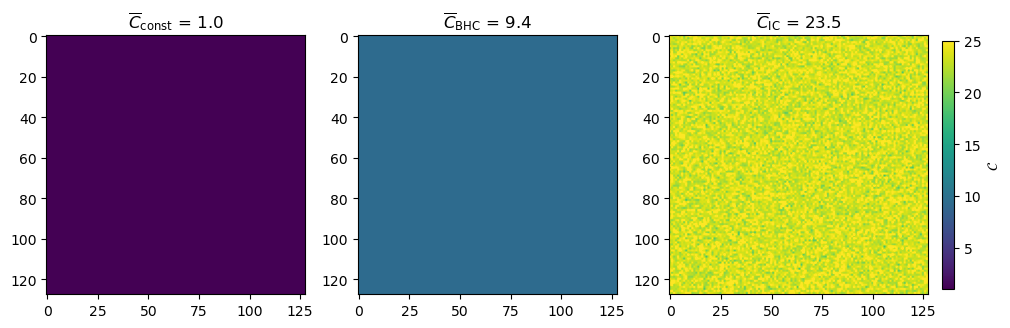

In [60]:
fig, axs = plt.subplots(figsize=(10, 8), nrows=1, ncols=3, constrained_layout=True)

axs[0].set_title('$\overline{C}_\mathrm{const}$ = %.1f' %const_clump.mean())
im = axs[0].imshow(const_clump[...,N//2], cmap='viridis', vmin=1, vmax=25)

axs[1].set_title('$\overline{C}_\mathrm{BHC}$ = %.1f' %homogeneous_clump.mean())
im = axs[1].imshow(homogeneous_clump[...,N//2], cmap='viridis', vmin=1, vmax=25)

axs[2].set_title('$\overline{C}_\mathrm{IC}$ = %.1f' %inhomogeneous_clump.mean())
im = axs[2].imshow(inhomogeneous_clump[...,N//2], cmap='viridis', vmin=1, vmax=25)
plt.colorbar(im, ax=axs[2], label=r'$\mathcal{C}$', pad=0.02, fraction=0.048)